📁 Saved future predictions to predicted_months.csv


/var/folders/xr/4y3sdfl15fg76yqhn07rpk140000gn/T/ipykernel_12688/379706976.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


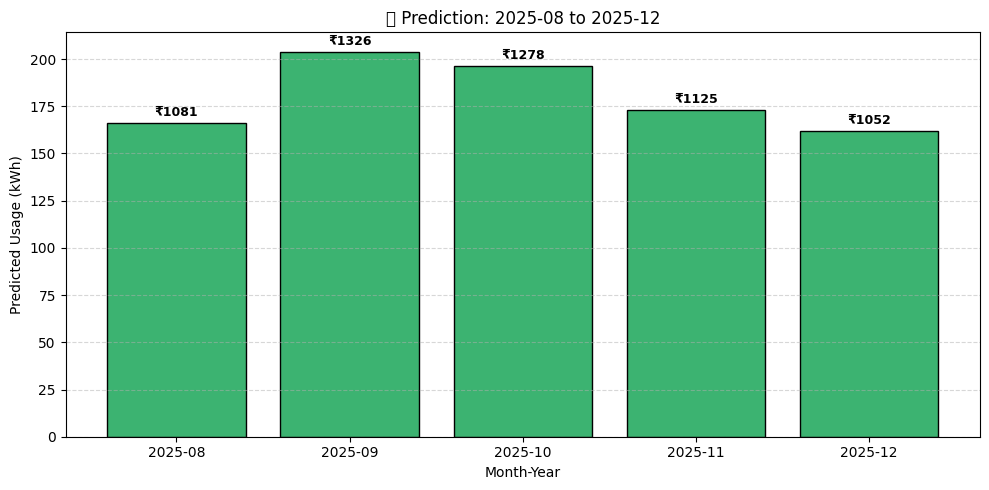

/var/folders/xr/4y3sdfl15fg76yqhn07rpk140000gn/T/ipykernel_12688/379706976.py:88: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


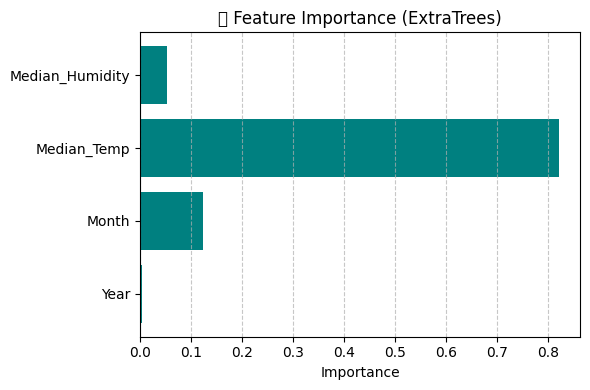

✅ Model saved as bill_predictor_model.pkl


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv("dataset.csv")

# --- Sanity Check ---
required_columns = ["Year", "Month", "Median_Temp", "Median_Humidity", "Total_kWh"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing one or more required columns in dataset.csv: {required_columns}")

df["Label"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)

# Detect latest recorded month and year
latest_year = df["Year"].max()
latest_month = df[df["Year"] == latest_year]["Month"].max()

# Train model on existing data
train_df = df[(df["Year"] < latest_year) | ((df["Year"] == latest_year) & (df["Month"] <= latest_month))]
X_train = train_df[["Year", "Month", "Median_Temp", "Median_Humidity"]].values
y_train = train_df["Total_kWh"].values

model = ExtraTreesRegressor(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict only if some months are left in the year
if latest_month < 12:
    months_remaining = list(range(latest_month + 1, 13))
    future_df = pd.DataFrame({
        "Year": [latest_year] * len(months_remaining),
        "Month": months_remaining
    })

    # Use recent 6 months’ median temp and humidity with slight noise
    recent = df.tail(6)
    median_temp = recent["Median_Temp"].median()
    median_humidity = recent["Median_Humidity"].median()

    np.random.seed(42)
    future_df["Median_Temp"] = median_temp + np.random.uniform(-1.5, 1.5, size=len(future_df))
    future_df["Median_Humidity"] = median_humidity + np.random.uniform(-3.0, 3.0, size=len(future_df))

    # Predict
    X_future = future_df[["Year", "Month", "Median_Temp", "Median_Humidity"]].values
    future_df["Predicted_kWh"] = model.predict(X_future)

    # Add realistic noise
    noise = np.random.uniform(-0.07, 0.1, size=len(future_df))
    future_df["Predicted_kWh"] *= (1 + noise)

    # Estimate bill
    future_df["Estimated_Bill"] = future_df["Predicted_kWh"] * 6.5
    future_df["Label"] = future_df["Year"].astype(str) + "-" + future_df["Month"].astype(str).str.zfill(2)

    # Save predictions to CSV (optional)
    future_df.to_csv("predicted_months.csv", index=False)
    print("📁 Saved future predictions to predicted_months.csv")

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(future_df["Label"], future_df["Predicted_kWh"],
                   color='mediumseagreen', edgecolor='black')

    for bar, bill in zip(bars, future_df["Estimated_Bill"]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
                 f"₹{bill:.0f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.title(f"📊 Prediction: {future_df['Label'].iloc[0]} to {future_df['Label'].iloc[-1]}")
    plt.xlabel("Month-Year")
    plt.ylabel("Predicted Usage (kWh)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("📅 All months of the latest year are already logged. No future predictions required.")

# Feature Importance Plot (optional)
importances = model.feature_importances_
features = ["Year", "Month", "Median_Temp", "Median_Humidity"]
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color="teal")
plt.xlabel("Importance")
plt.title("📌 Feature Importance (ExtraTrees)")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(model, "bill_predictor_model.pkl")
print("✅ Model saved as bill_predictor_model.pkl")